 # Home Credit Default Risk Prediction



 This notebook aims to develop and evaluate machine learning models to predict loan defaulters using the Home Credit Group dataset from a Kaggle competition.

 ## 1. Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (roc_auc_score, precision_recall_curve,
roc_curve, precision_score, recall_score, f1_score, confusion_matrix, auc)
from sklearn.utils.class_weight import compute_class_weight 
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from joblib import parallel_backend
import pickle
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

 ## 2. Load and Prepare Data

In [2]:
train_data = pd.read_csv('processed_train.csv')
test_data = pd.read_csv('processed_test.csv')

train_target = pd.read_csv('train_target.csv')

sk_id_train = pd.read_csv('sk_id_train.csv')
sk_id_test = pd.read_csv('sk_id_test.csv')

with open('final_cols.pkl', 'rb') as f:
    final_cols = pickle.load(f)


 ## 3. Feature Selection and Data Preprocessing

In [3]:
def get_available_columns(data, columns):
    available_cols = [col for col in columns if col in data.columns]
    missing_cols = [col for col in columns if col not in data.columns]
    
    print(f"Number of available columns: {len(available_cols)}")
    print(f"Number of missing columns: {len(missing_cols)}")
    
    if missing_cols:
        print("\nFirst 10 missing columns:")
        for col in missing_cols[:10]:
            print(f"- {col}")
        if len(missing_cols) > 10:
            print(f"... and {len(missing_cols) - 10} more")
    
    return available_cols

print("Train data:")
train_available_cols = get_available_columns(train_data, final_cols)

print("\nTest data:")
test_available_cols = get_available_columns(test_data, final_cols)

final_available_cols = list(set(train_available_cols) & set(test_available_cols))
print(f"\nFinal number of columns to use: {len(final_available_cols)}")


Train data:
Number of available columns: 453
Number of missing columns: 26

First 10 missing columns:
- PREV_PREV_AMT_ANNUITY_MAX_INCOME_RATIO
- BUREAU_BURO_DAYS_CREDIT_MEAN_REGISTRATION_DIFF
- PREV_PREV_AMT_GOODS_PRICE_MAX_INCOME_RATIO
- PREV_PREV_AMT_GOODS_PRICE_MEAN_INCOME_RATIO
- BUREAU_BURO_DAYS_CREDIT_MAX_REGISTRATION_DIFF
- CC_CC_AMT_RECIVABLE_MEAN_INCOME_RATIO
- CC_CC_AMT_RECEIVABLE_PRINCIPAL_MEAN_INCOME_RATIO
- BUREAU_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN_INCOME_RATIO
- BUREAU_BURO_AMT_ANNUITY_SUM_INCOME_RATIO
- BUREAU_BURO_AMT_CREDIT_SUM_OVERDUE_MAX_INCOME_RATIO
... and 16 more

Test data:
Number of available columns: 453
Number of missing columns: 26

First 10 missing columns:
- PREV_PREV_AMT_ANNUITY_MAX_INCOME_RATIO
- BUREAU_BURO_DAYS_CREDIT_MEAN_REGISTRATION_DIFF
- PREV_PREV_AMT_GOODS_PRICE_MAX_INCOME_RATIO
- PREV_PREV_AMT_GOODS_PRICE_MEAN_INCOME_RATIO
- BUREAU_BURO_DAYS_CREDIT_MAX_REGISTRATION_DIFF
- CC_CC_AMT_RECIVABLE_MEAN_INCOME_RATIO
- CC_CC_AMT_RECEIVABLE_PRINCIPAL_MEAN_I

In [4]:
def preprocess_features(X):
    X = X.replace([np.inf, -np.inf], np.nan)
    
    cols_with_nan = X.columns[X.isna().any()].tolist()
    
    for col in cols_with_nan:
        low = X[col].quantile(0.01)
        high = X[col].quantile(0.99)
        X[col] = X[col].clip(low, high)
        X[col] = X[col].fillna(X[col].median())
    
    return X

X = train_data[final_available_cols]
y = train_target['TARGET']

X = preprocess_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 ## 4. Hyperparameter Tuning with Optuna for Multiple Models

In [5]:
neg_class_count = len(y[y == 0])
pos_class_count = len(y[y == 1])
imbalance_ratio = neg_class_count / pos_class_count

print(f"Dataset class distribution:")
print(f"Negative class (0): {neg_class_count:,} samples")
print(f"Positive class (1): {pos_class_count:,} samples")
print(f"Imbalance ratio (neg/pos): {imbalance_ratio:.2f}")

scale_pos_min = max(1, imbalance_ratio * 0.5)
scale_pos_max = imbalance_ratio * 1.5

print(f"\nSetting scale_pos_weight range: [{scale_pos_min:.2f}, {scale_pos_max:.2f}]")

Dataset class distribution:
Negative class (0): 282,686 samples
Positive class (1): 24,825 samples
Imbalance ratio (neg/pos): 11.39

Setting scale_pos_weight range: [5.69, 17.08]


In [6]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42)

print("\nStarting optimization process...")
print(f"Using {len(X_sample):,} samples for optimization ({len(X_sample)/len(X)*100:.1f}% of full dataset)")


Starting optimization process...
Using 92,253 samples for optimization (30.0% of full dataset)


In [7]:
def optimize_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_pos_min, scale_pos_max)
    }
    
    model = lgb.LGBMClassifier(**params, random_state=42)
    return np.mean(cross_val_score(model, X_sample, y_sample, cv=5, scoring='roc_auc'))

def optimize_rf(trial):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_sample), y=y_sample)
    class_weight_dict = dict(zip(np.unique(y_sample), class_weights))
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'class_weight': 'balanced'
    }
    
    model = RandomForestClassifier(**params, random_state=42)
    return np.mean(cross_val_score(model, X_sample, y_sample, cv=5, scoring='roc_auc'))

def optimize_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_pos_min, scale_pos_max)
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)
    return np.mean(cross_val_score(model, X_sample, y_sample, cv=5, scoring='roc_auc'))

In [8]:
print("Starting optimization process...")

print("\nOptimizing LightGBM...")
with parallel_backend('threading', n_jobs=-1):
    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(optimize_lgbm, n_trials=20)

print("\nOptimizing Random Forest...")
with parallel_backend('threading', n_jobs=-1):
    study_rf = optuna.create_study(direction='maximize')
    study_rf.optimize(optimize_rf, n_trials=20)

print("\nOptimizing XGBoost...")
with parallel_backend('threading', n_jobs=-1):
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(optimize_xgb, n_trials=20)

print("\nOptimization completed!")
print("\nBest LightGBM parameters:", study_lgbm.best_params)
print("Best score:", study_lgbm.best_value)

print("\nBest Random Forest parameters:", study_rf.best_params)
print("Best score:", study_rf.best_value)

print("\nBest XGBoost parameters:", study_xgb.best_params)
print("Best score:", study_xgb.best_value)

[I 2024-10-22 18:02:21,727] A new study created in memory with name: no-name-0f6de101-447a-4a4d-b3a4-23079299a577


Starting optimization process...

Optimizing LightGBM...


[I 2024-10-22 18:03:33,319] Trial 0 finished with value: 0.6955359105103307 and parameters: {'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.4873777185743595, 'subsample': 0.8506226541591957, 'colsample_bytree': 0.9968028369053379, 'min_child_weight': 5, 'scale_pos_weight': 16.664549501473232}. Best is trial 0 with value: 0.6955359105103307.
[I 2024-10-22 18:04:40,017] Trial 1 finished with value: 0.7731700836678417 and parameters: {'n_estimators': 319, 'max_depth': 9, 'learning_rate': 0.06367584152694634, 'subsample': 0.7484251271397995, 'colsample_bytree': 0.7759885252037698, 'min_child_weight': 5, 'scale_pos_weight': 6.412926714685638}. Best is trial 1 with value: 0.7731700836678417.
[I 2024-10-22 18:05:33,347] Trial 2 finished with value: 0.7712024571308586 and parameters: {'n_estimators': 332, 'max_depth': 7, 'learning_rate': 0.0584024857539647, 'subsample': 0.8739318072172041, 'colsample_bytree': 0.8352625872658744, 'min_child_weight': 2, 'scale_pos_weight': 13.565820343


Optimizing Random Forest...


[I 2024-10-22 18:23:58,461] Trial 0 finished with value: 0.7530466215100711 and parameters: {'n_estimators': 275, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7530466215100711.
[I 2024-10-22 18:26:46,889] Trial 1 finished with value: 0.7547156963393732 and parameters: {'n_estimators': 272, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7547156963393732.
[I 2024-10-22 18:28:42,386] Trial 2 finished with value: 0.7551042706587727 and parameters: {'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.7551042706587727.
[I 2024-10-22 18:30:25,430] Trial 3 finished with value: 0.7544559956502203 and parameters: {'n_estimators': 207, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7551042706587727.
[I 2024-10-22 18:31:23,764] Trial 4 finished with value: 0.7490108099125601 and parameters: {'


Optimizing XGBoost...


[I 2024-10-22 18:56:56,750] Trial 0 finished with value: 0.7022917510848175 and parameters: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.4907191212231164, 'subsample': 0.7982303694920068, 'colsample_bytree': 0.7378993220087913, 'scale_pos_weight': 9.216900405541693}. Best is trial 0 with value: 0.7022917510848175.
[I 2024-10-22 18:59:05,827] Trial 1 finished with value: 0.7338606824273475 and parameters: {'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.18433457271756645, 'subsample': 0.9075781095870743, 'colsample_bytree': 0.87926690508804, 'scale_pos_weight': 11.122266688061409}. Best is trial 1 with value: 0.7338606824273475.
[I 2024-10-22 19:01:05,074] Trial 2 finished with value: 0.7347764700212924 and parameters: {'n_estimators': 181, 'max_depth': 10, 'learning_rate': 0.16583940534568647, 'subsample': 0.7996800215547776, 'colsample_bytree': 0.8729133888268621, 'scale_pos_weight': 9.930861816567823}. Best is trial 2 with value: 0.7347764700212924.
[I 2024-10-22 


Optimization completed!

Best LightGBM parameters: {'n_estimators': 444, 'max_depth': 8, 'learning_rate': 0.01959126070528827, 'subsample': 0.998904705086652, 'colsample_bytree': 0.8821305267192184, 'min_child_weight': 2, 'scale_pos_weight': 7.025752581570452}
Best score: 0.7790560106609893

Best Random Forest parameters: {'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2}
Best score: 0.7551042706587727

Best XGBoost parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.056641221057444104, 'subsample': 0.924354388300201, 'colsample_bytree': 0.9956121988327886, 'scale_pos_weight': 5.8480854933671695}
Best score: 0.780579176099272


 ## 5. Train and Evaluate Individual Models

LightGBM Evaluation:
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.882929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86641
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
AUC-ROC: 0.7870
Precision: 0.2328
Recall: 0.5472
F1 Score: 0.3266
Confusion Matrix:
[[47630  8924]
 [ 2241  2708]]


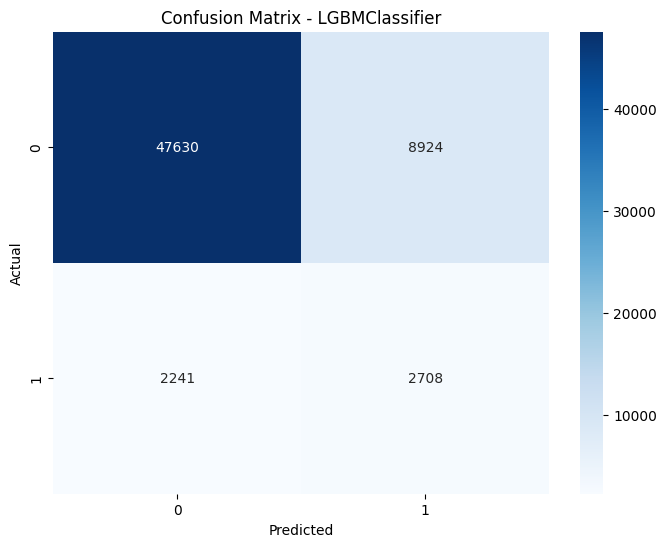


Random Forest Evaluation:
AUC-ROC: 0.7602
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[56554     0]
 [ 4949     0]]


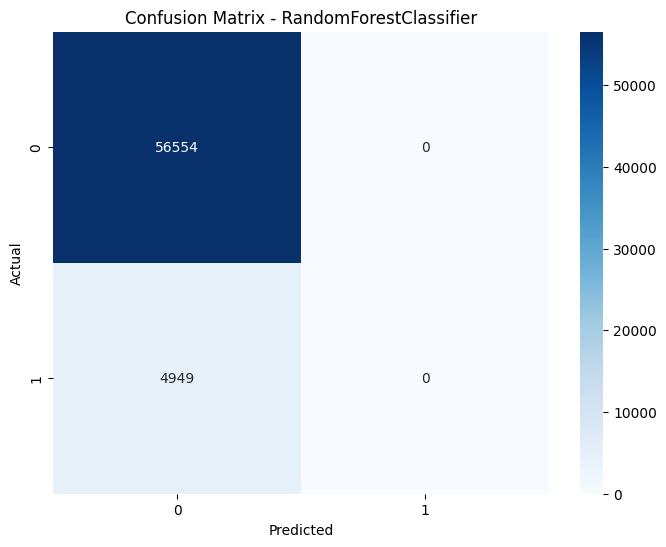


XGBoost Evaluation:
AUC-ROC: 0.7850
Precision: 0.2583
Recall: 0.4791
F1 Score: 0.3356
Confusion Matrix:
[[49745  6809]
 [ 2578  2371]]


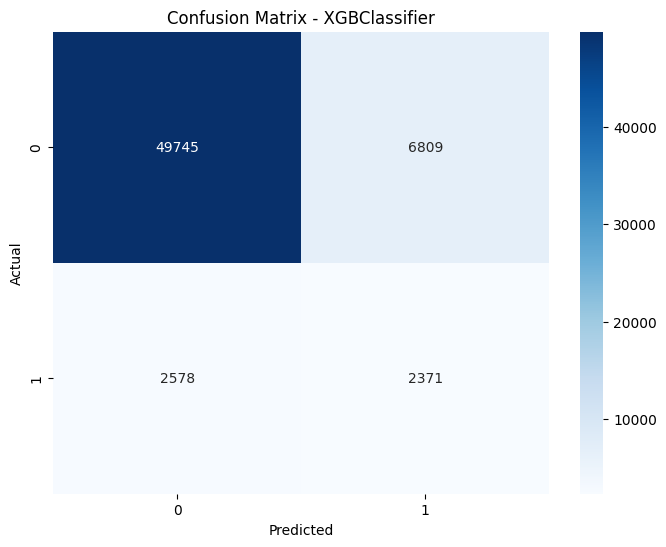

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return {
        'model': model,
        'auc_roc': auc_roc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("LightGBM Evaluation:")
best_lgbm = lgb.LGBMClassifier(**study_lgbm.best_params, random_state=42)
lgbm_results = evaluate_model(best_lgbm, X_train, X_test, y_train, y_test)

print("\nRandom Forest Evaluation:")
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
rf_results = evaluate_model(best_rf, X_train, X_test, y_train, y_test)

print("\nXGBoost Evaluation:")
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, random_state=42)
xgb_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test)


 ## 6. Select Best Model

In [10]:
all_results = [lgbm_results, rf_results, xgb_results]

best_model = max(all_results, key=lambda x: x['auc_roc'])

print(f"Best Model: {best_model['model'].__class__.__name__}")
print(f"AUC-ROC: {best_model['auc_roc']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1 Score: {best_model['f1']:.4f}")


Best Model: LGBMClassifier
AUC-ROC: 0.7870
Precision: 0.2328
Recall: 0.5472
F1 Score: 0.3266


 ## 7. Create and Train Stacking Classifier

Stacking Classifier Evaluation:
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.387736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86641
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.691356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86625
[LightGBM] [Info] Number of data points i

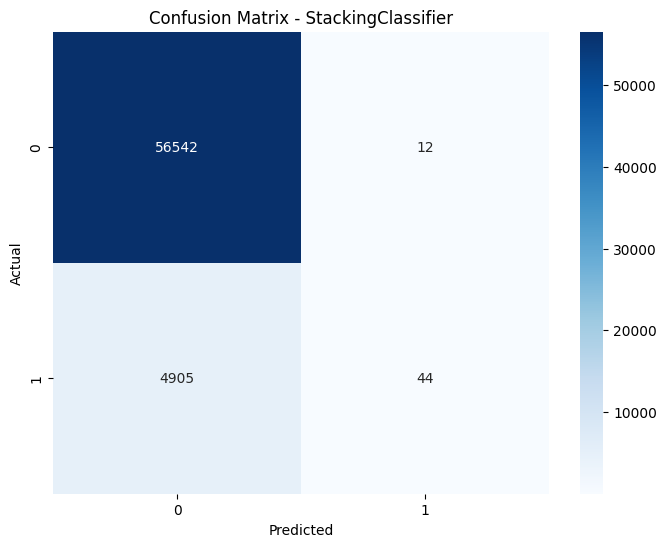


Comparison:
Best Individual Model (LGBMClassifier):
AUC-ROC: 0.7870
Precision: 0.2328
Recall: 0.5472
F1 Score: 0.3266

Stacking Classifier:
AUC-ROC: 0.7873
Precision: 0.7857
Recall: 0.0089
F1 Score: 0.0176


In [11]:
base_models = [
    ('lgb', best_lgbm),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5,
    stack_method='predict_proba'
)

print("Stacking Classifier Evaluation:")
stacking_results = evaluate_model(stacking_classifier, X_train, X_test, y_train, y_test)

print("\nComparison:")
print(f"Best Individual Model ({best_model['model'].__class__.__name__}):")
print(f"AUC-ROC: {best_model['auc_roc']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1 Score: {best_model['f1']:.4f}")

print("\nStacking Classifier:")
print(f"AUC-ROC: {stacking_results['auc_roc']:.4f}")
print(f"Precision: {stacking_results['precision']:.4f}")
print(f"Recall: {stacking_results['recall']:.4f}")
print(f"F1 Score: {stacking_results['f1']:.4f}")


## 8. Threshold optimization

In [20]:
def optimize_threshold(y_true, y_prob, thresholds=None, plot=True):
    """
    Find optimal threshold based on multiple metrics
    
    Parameters:
    y_true: True labels
    y_prob: Predicted probabilities
    thresholds: Array of thresholds to test (default: np.arange(0.1, 0.9, 0.05))
    plot: Whether to plot the metrics curves
    
    Returns:
    dict with optimal thresholds for different metrics and visualization
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.05)
    
    results = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'balanced_accuracy': []
    }
    
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        balanced_acc = (tp/(tp+fn) + tn/(tn+fp))/2
        
        results['threshold'].append(threshold)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['balanced_accuracy'].append(balanced_acc)
    
    results_df = pd.DataFrame(results)
    
    optimal_thresholds = {
        'f1': results_df.loc[results_df['f1'].idxmax(), 'threshold'],
        'balanced_accuracy': results_df.loc[results_df['balanced_accuracy'].idxmax(), 'threshold'],
        'precision_recall_balance': results_df.loc[(results_df['precision'] - results_df['recall']).abs().idxmin(), 'threshold']
    }
    
    if plot:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
        plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
        plt.plot(results_df['threshold'], results_df['f1'], label='F1')
        plt.plot(results_df['threshold'], results_df['balanced_accuracy'], label='Balanced Accuracy')
        
        for metric, threshold in optimal_thresholds.items():
            plt.axvline(x=threshold, linestyle='--', alpha=0.5, label=f'Optimal {metric}: {threshold:.3f}')
        
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Metrics vs Threshold')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        plt.plot(recall, precision, label=f'PR Curve (AUC = {auc(recall, precision):.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    print("\nResults for optimal thresholds:")
    for metric, threshold in optimal_thresholds.items():
        y_pred = (y_prob > threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        balanced_acc = (tp/(tp+fn) + tn/(tn+fp))/2
        
        print(f"\nOptimal threshold for {metric}: {threshold:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        print(f"Balanced Accuracy: {balanced_acc:.3f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
    
    return optimal_thresholds, results_df

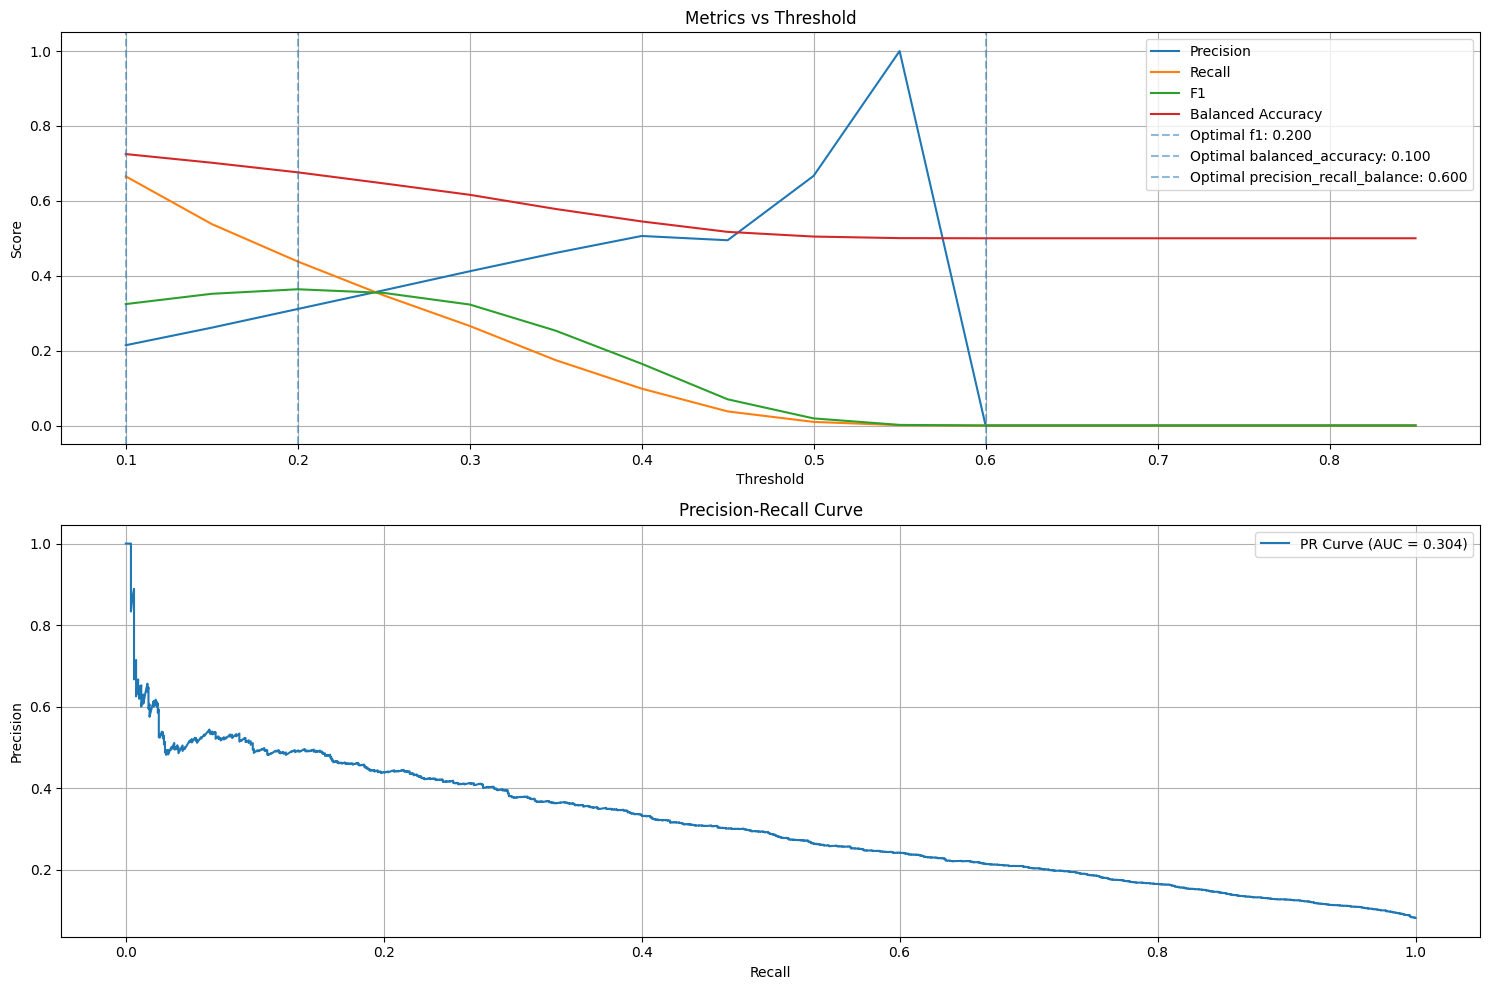


Results for optimal thresholds:

Optimal threshold for f1: 0.200
Precision: 0.311
Recall: 0.438
F1 Score: 0.364
Balanced Accuracy: 0.676
Confusion Matrix:
[[12916  1211]
 [  702   547]]

Optimal threshold for balanced_accuracy: 0.100
Precision: 0.214
Recall: 0.665
F1 Score: 0.324
Balanced Accuracy: 0.725
Confusion Matrix:
[[11082  3045]
 [  418   831]]

Optimal threshold for precision_recall_balance: 0.600
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Balanced Accuracy: 0.500
Confusion Matrix:
[[14127     0]
 [ 1249     0]]

Stacking Classifier Results with Optimal Threshold:
AUC-ROC: 0.7788
Precision: 0.2763
Recall: 0.3874
F1 Score: 0.3225
Confusion Matrix:
[[12942  1226]
 [  740   468]]


In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

val_predictions = stacking_classifier.predict_proba(X_val)[:, 1]

optimal_thresholds, results_df = optimize_threshold(y_val, val_predictions)

test_predictions = stacking_classifier.predict_proba(X_test)[:, 1]
final_predictions = (test_predictions > optimal_thresholds['f1']).astype(int)

print("\nStacking Classifier Results with Optimal Threshold:")
print(f"AUC-ROC: {roc_auc_score(y_test, test_predictions):.4f}")
print(f"Precision: {precision_score(y_test, final_predictions):.4f}")
print(f"Recall: {recall_score(y_test, final_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, final_predictions):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_predictions))

 ## 9. Make Predictions on Test Set

In [27]:
final_model = stacking_classifier if stacking_results['auc_roc'] > best_model['auc_roc'] else best_model['model']

optimal_threshold = 0.2  # F1 threshold, or use 0.1 for balanced accuracy threshold

X_test_final = test_data[final_available_cols]
X_test_final = preprocess_features(X_test_final)

test_predictions_prob = final_model.predict_proba(X_test_final)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': sk_id_test['SK_ID_CURR'],
    'TARGET': test_predictions_prob  # Using probabilities for submission
})

submission.to_csv('submission_final_prob.csv', index=False)
print("Probabilities submission file created successfully.")

binary_predictions = (test_predictions_prob > optimal_threshold).astype(int)
binary_submission = pd.DataFrame({
    'SK_ID_CURR': sk_id_test['SK_ID_CURR'],
    'TARGET': binary_predictions
})

# Print submission summary
print("\nSubmission Summary:")
print(f"Total predictions: {len(test_predictions_prob)}")
print(f"Using threshold: {optimal_threshold}")
print(f"Predicted defaults (binary): {binary_predictions.sum()}")
print(f"Percentage defaults: {(binary_predictions.sum() / len(binary_predictions)) * 100:.2f}%")

Probabilities submission file created successfully.

Submission Summary:
Total predictions: 48744
Using threshold: 0.2
Predicted defaults (binary): 4280
Percentage defaults: 8.78%


## 10. Saving the models

In [25]:
def save_models(stacking_classifier, base_models, final_available_cols, optimal_threshold, 
                performance_metrics, output_dir='models'):
    """
    Save models with optimal threshold and performance metrics
    
    Parameters:
    -----------
    stacking_classifier : StackingClassifier
        The trained stacking classifier
    base_models : list of tuples
        List of (name, model) tuples for the base models
    final_available_cols : list
        List of feature columns used in training
    optimal_threshold : float
        The optimal threshold for binary predictions
    performance_metrics : dict
        Dictionary containing model performance metrics
    output_dir : str
        Directory to save the models and metadata
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    features_file = os.path.join(output_dir, f'feature_columns_{timestamp}.pkl')
    joblib.dump(final_available_cols, features_file)
    
    base_model_files = {}
    for name, model in base_models:
        model_file = os.path.join(output_dir, f'{name}_model_{timestamp}.pkl')
        joblib.dump(model, model_file)
        base_model_files[name] = model_file
    
    stacking_file = os.path.join(output_dir, f'stacking_classifier_{timestamp}.pkl')
    joblib.dump(stacking_classifier, stacking_file)
    
    metadata = {
        'timestamp': timestamp,
        'feature_columns': features_file,
        'base_models': base_model_files,
        'stacking_classifier': stacking_file,
        'optimal_threshold': optimal_threshold,
        'performance_metrics': {
            'validation': performance_metrics.get('validation', {}),
            'test': performance_metrics.get('test', {})
        },
        'model_parameters': {
            'stacking_classifier': str(stacking_classifier.get_params()),
            'base_models': {name: str(model.get_params()) for name, model in base_models}
        }
    }
    
    metadata_file = os.path.join(output_dir, f'model_metadata_{timestamp}.pkl')
    joblib.dump(metadata, metadata_file)
    
    metadata_readable = {
        'timestamp': timestamp,
        'optimal_threshold': optimal_threshold,
        'performance_metrics': metadata['performance_metrics'],
        'feature_count': len(final_available_cols)
    }
    
    with open(os.path.join(output_dir, f'model_summary_{timestamp}.txt'), 'w') as f:
        f.write("Model Summary\n")
        f.write("=============\n\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Optimal Threshold: {optimal_threshold}\n\n")
        f.write("Performance Metrics:\n")
        f.write("-------------------\n")
        for dataset, metrics in metadata['performance_metrics'].items():
            f.write(f"\n{dataset.capitalize()} Set:\n")
            for metric, value in metrics.items():
                f.write(f"{metric}: {value:.4f}\n")
        
        f.write(f"\nNumber of features: {len(final_available_cols)}\n")
    
    print(f"Models saved successfully in {output_dir}")
    print(f"Model summary saved to: model_summary_{timestamp}.txt")
    return metadata

performance_metrics = {
    'validation': {
        'auc_roc': 0.7788,
        'precision': 0.2763,
        'recall': 0.3874,
        'f1_score': 0.3225
    },
    'test': {
        'auc_roc': roc_auc_score(y_test, test_predictions),
        'precision': precision_score(y_test, final_predictions),
        'recall': recall_score(y_test, final_predictions),
        'f1_score': f1_score(y_test, final_predictions)
    }
}

In [26]:
metadata = save_models(
    stacking_classifier=stacking_classifier,
    base_models=base_models,
    final_available_cols=final_available_cols,
    optimal_threshold=0.2,
    performance_metrics=performance_metrics,
    output_dir='models'
)

Models saved successfully in models
Model summary saved to: model_summary_20241022_215059.txt


 ## 11. Conclusion



 In this notebook, we've developed and evaluated multiple models for the Home Credit Default Risk prediction task. We've used LightGBM, Random Forest, XGBoost, and a Stacking Classifier.



 Key steps:

 1. Data preparation and preprocessing

 2. Hyperparameter tuning using Optuna

 3. Individual model training and evaluation

 4. Stacking Classifier implementation

 5. Final model selection and prediction